In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from ta.momentum import RSIIndicator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# --- Configuration ---
TICKERS = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'MRNA', 'JNJ', 'ILMN', 'NEE', 'NFLX', 'FSLR']
START_DATE = '2019-7-05'
END_DATE = '2025-01-02'
time_steps = 60  # Number of days to look back
risk_free_rate_daily = 0.05 / 252  # Approximate daily risk-free rate

# Define sector map for portfolio grouping
SECTOR_MAP = {
    'AAPL': 'Tech',
    'MSFT': 'Tech',
    'AMZN': 'Tech',
    'TSLA': 'Tech',
    'NFLX': 'Media',
    'MRNA': 'Health',
    'JNJ': 'Health',
    'ILMN': 'Health',
    'NEE': 'Energy',
    'FSLR': 'Energy'
}

# Create an empty list to hold all stock data for each ticker
all_stock = []
for ticker in TICKERS:
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=START_DATE, end=END_DATE)
    
    data['Ticker'] = ticker
    
    all_stock.append(data)

all_df = pd.concat(all_stock)
all_df.reset_index(inplace=True)
all_df.to_csv('all_stock_data.csv', index=False)



[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [2]:

def load_and_preprocess_data(ticker):
    data = yf.download(ticker, start=START_DATE, end=END_DATE)
    df = data[['Close']].copy()
    df['Rolling_Mean_5'] = df['Close'].rolling(5).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['Upper_Band'] = df['Close'].rolling(window=20).mean() + (df['Close'].rolling(window=20).std() * 2)
    df['Lower_Band'] = df['Close'].rolling(window=20).mean() - (df['Close'].rolling(window=20).std() * 2)

    df.dropna(inplace=True)

    features = ['Close', 'Rolling_Mean_5', 'EMA_12', 'EMA_26', 'SMA_20', 'Upper_Band', 'Lower_Band']
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    df['Target_10_Days'] = df['Close'].shift(-10)
    df.dropna(inplace=True)

    return df, features

In [3]:

def create_sequences(df, features, time_steps):
    data = df[features + ['Target_10_Days']].values
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])
        y.append(data[i+time_steps, -1])
    return np.array(X), np.array(y)


In [4]:
def train_lstm_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer='l2'))
    model.add(Dropout(0.6))
    model.add(LSTM(96, return_sequences=False, kernel_regularizer='l2'))
    model.add(Dropout(0.6))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    return model


[*********************100%***********************]  1 of 1 completed

Processing: AAPL



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-13 19:58:26.439476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


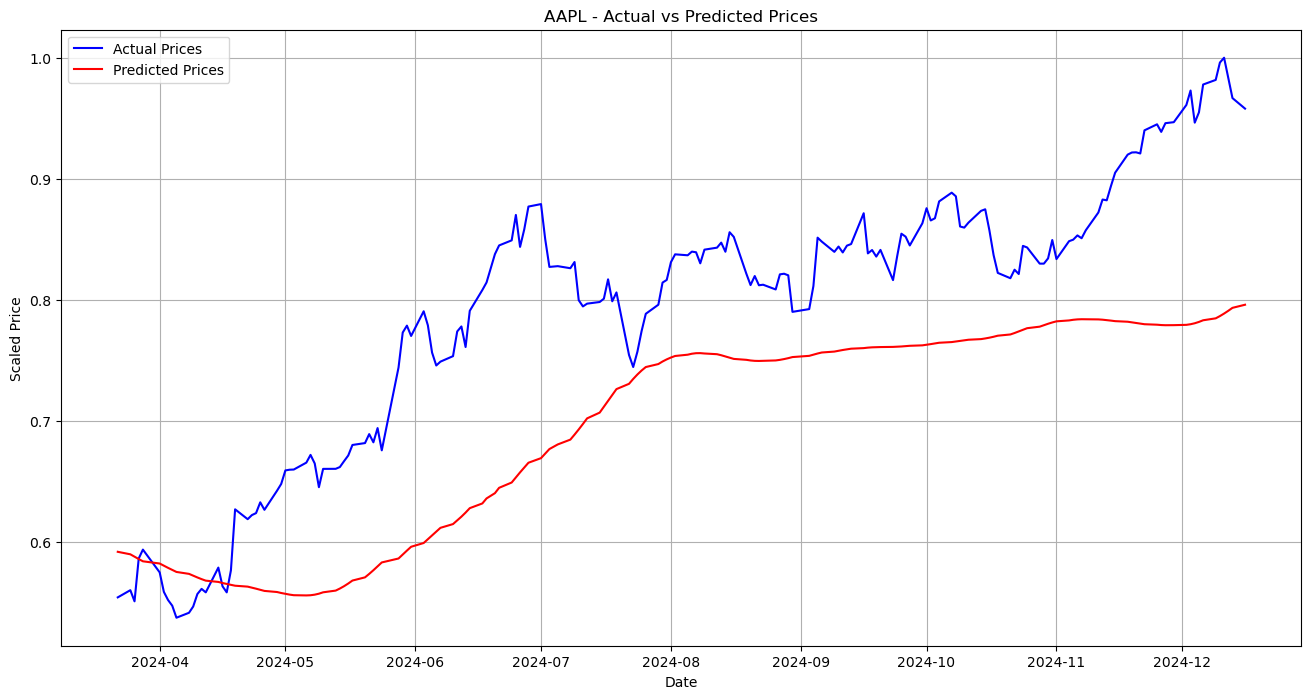

Processing: MSFT


[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-13 19:59:56.115072: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


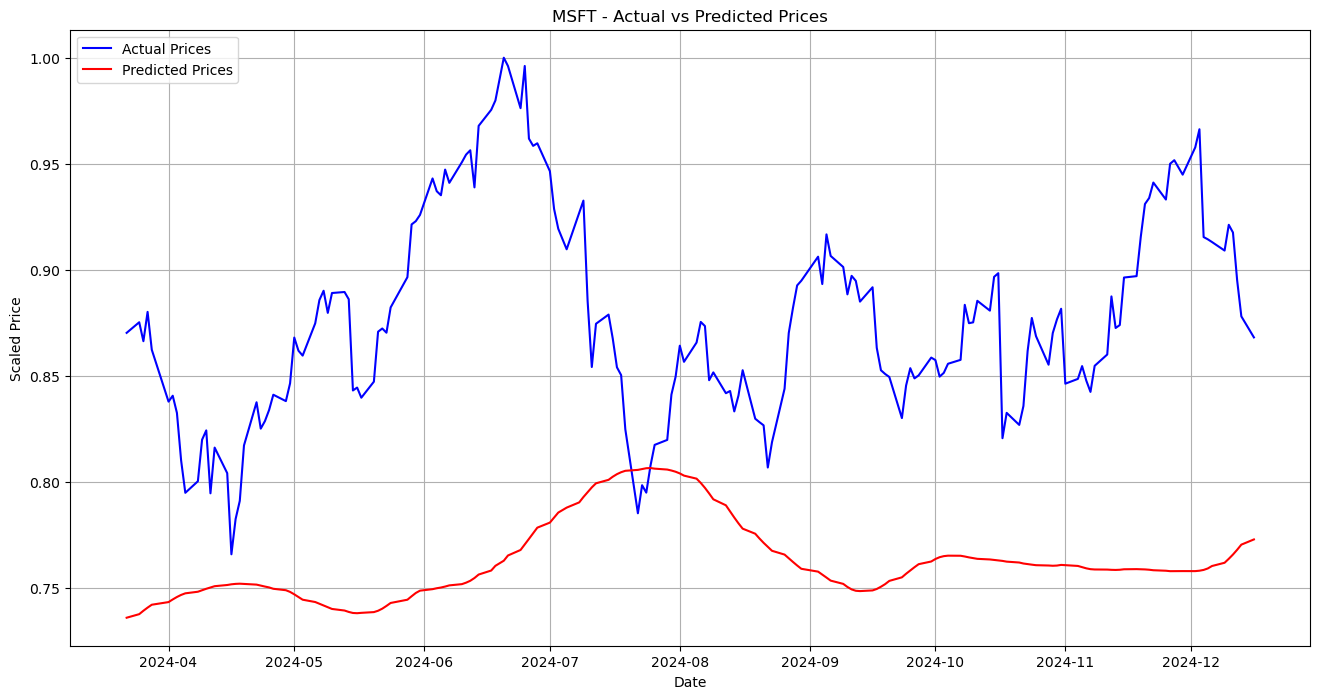

Processing: AMZN


[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


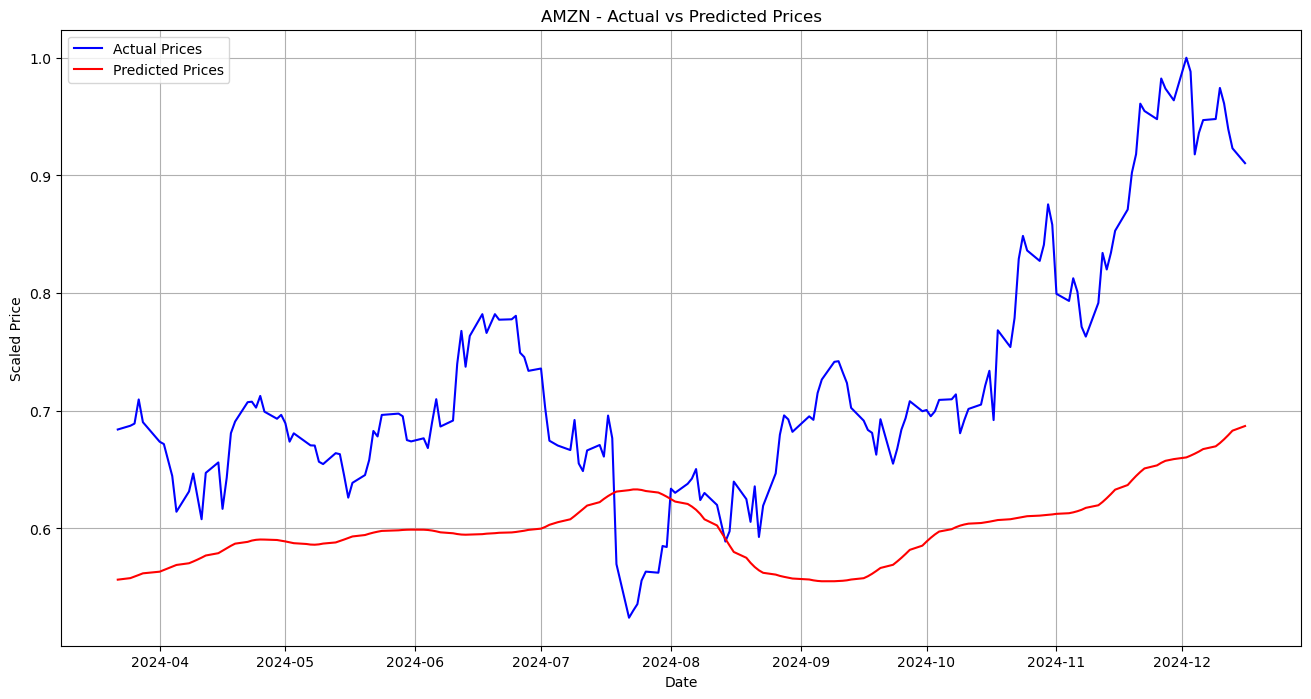

[*********************100%***********************]  1 of 1 completed

Processing: TSLA



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-13 20:01:28.194559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


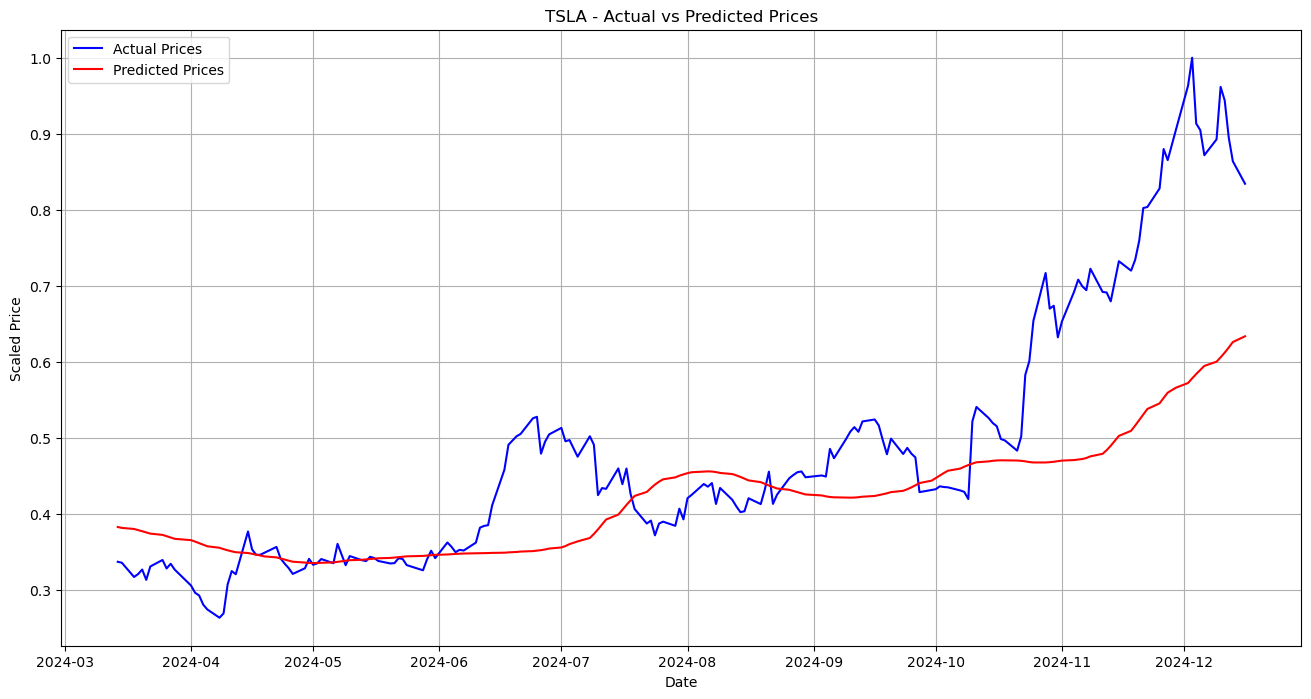

[*********************100%***********************]  1 of 1 completed

Processing: MRNA



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


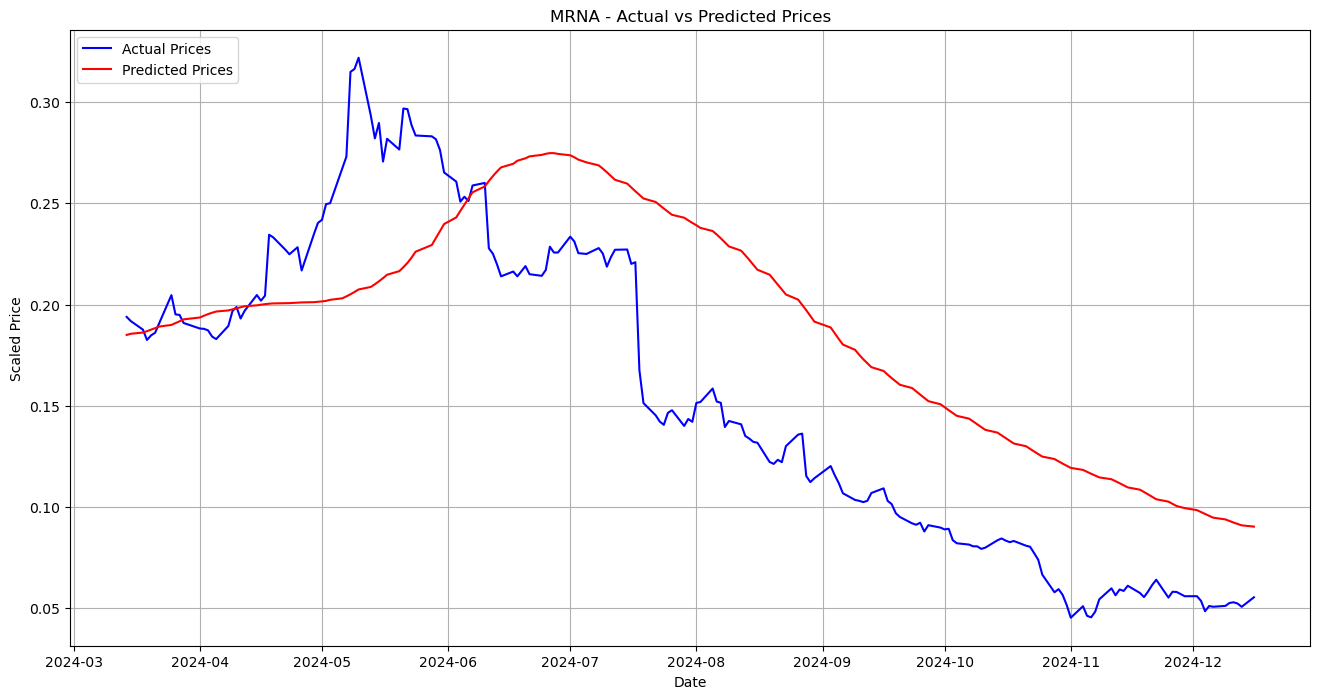

Processing: JNJ


[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-13 20:02:42.794512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


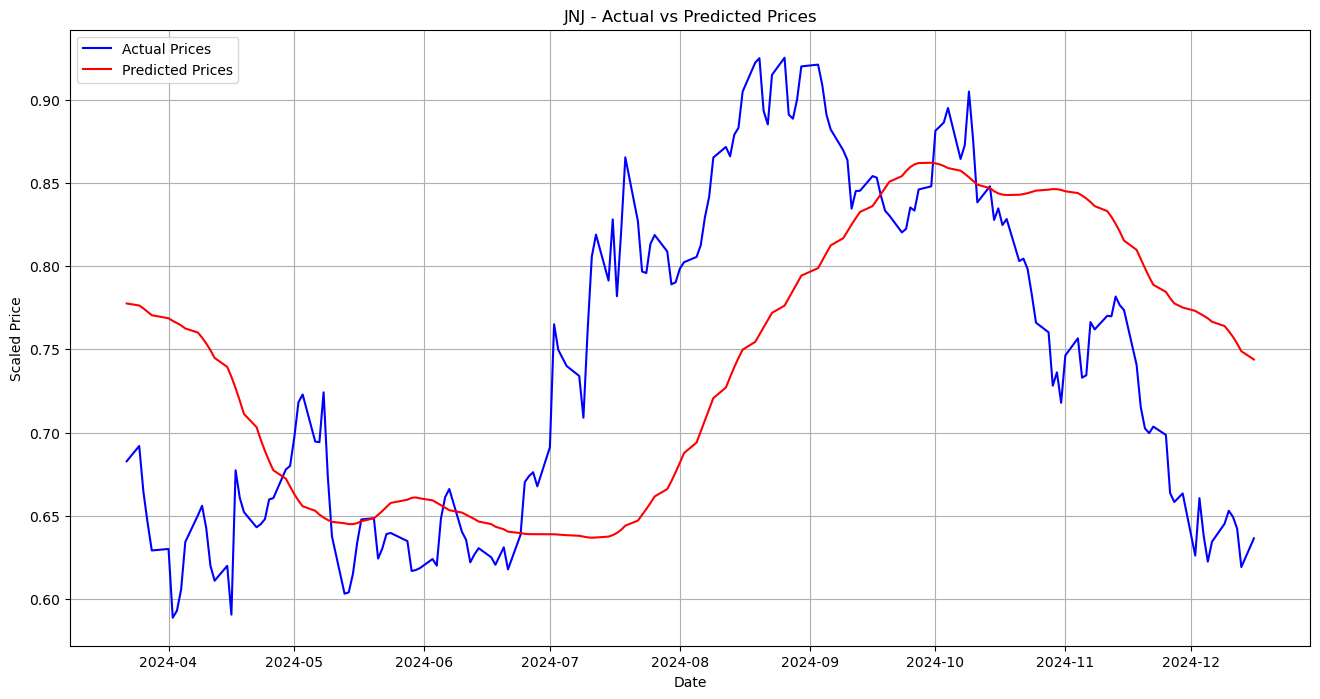

[*********************100%***********************]  1 of 1 completed

Processing: ILMN



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


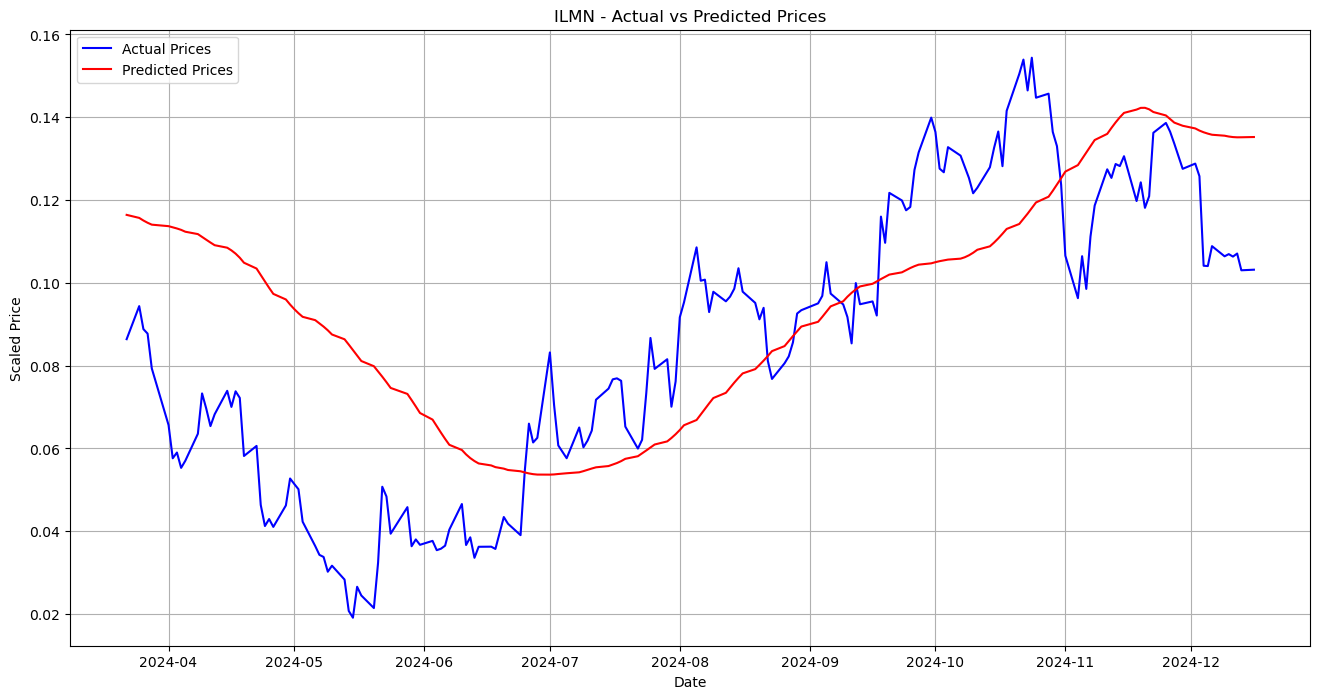

[*********************100%***********************]  1 of 1 completed

Processing: NEE



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-13 20:04:02.759662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


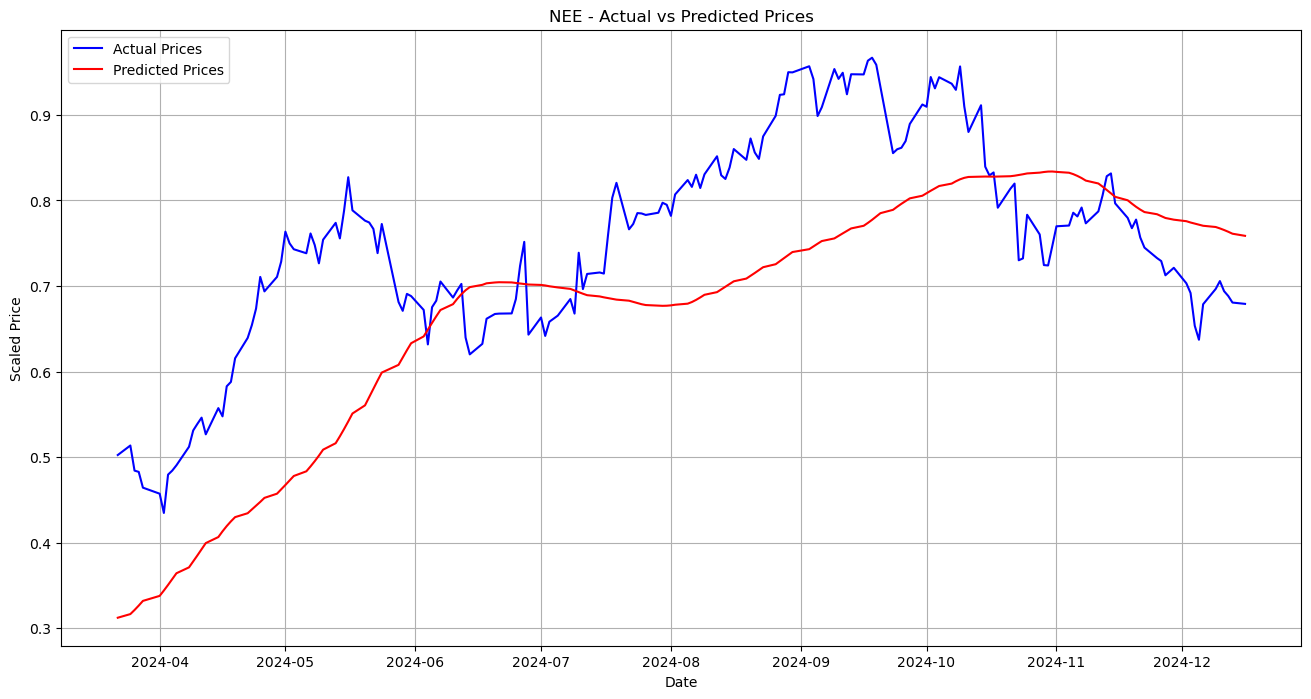

[*********************100%***********************]  1 of 1 completed

Processing: NFLX



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


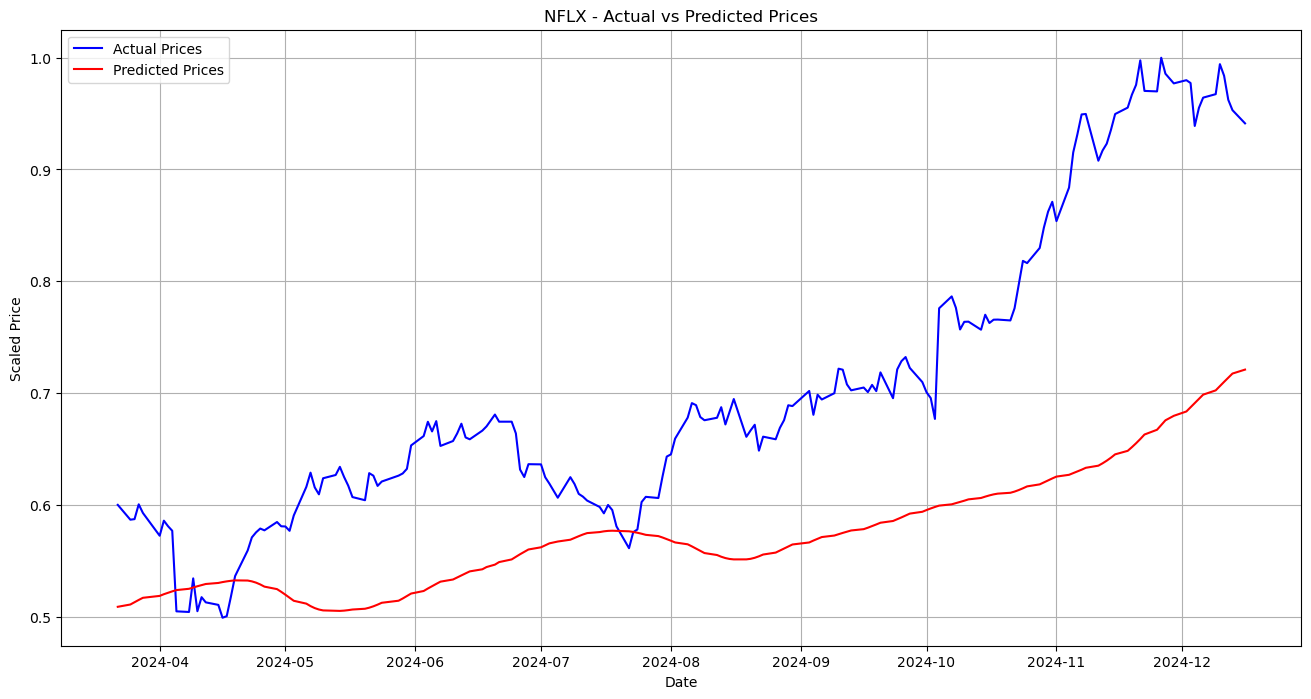

[*********************100%***********************]  1 of 1 completed

Processing: FSLR



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step

2025-05-13 20:05:19.808626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


/var/folders/vl/cjx_brsd3fq4nnncxqsxk6tm0000gn/T/ipykernel_86836/1877505842.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])


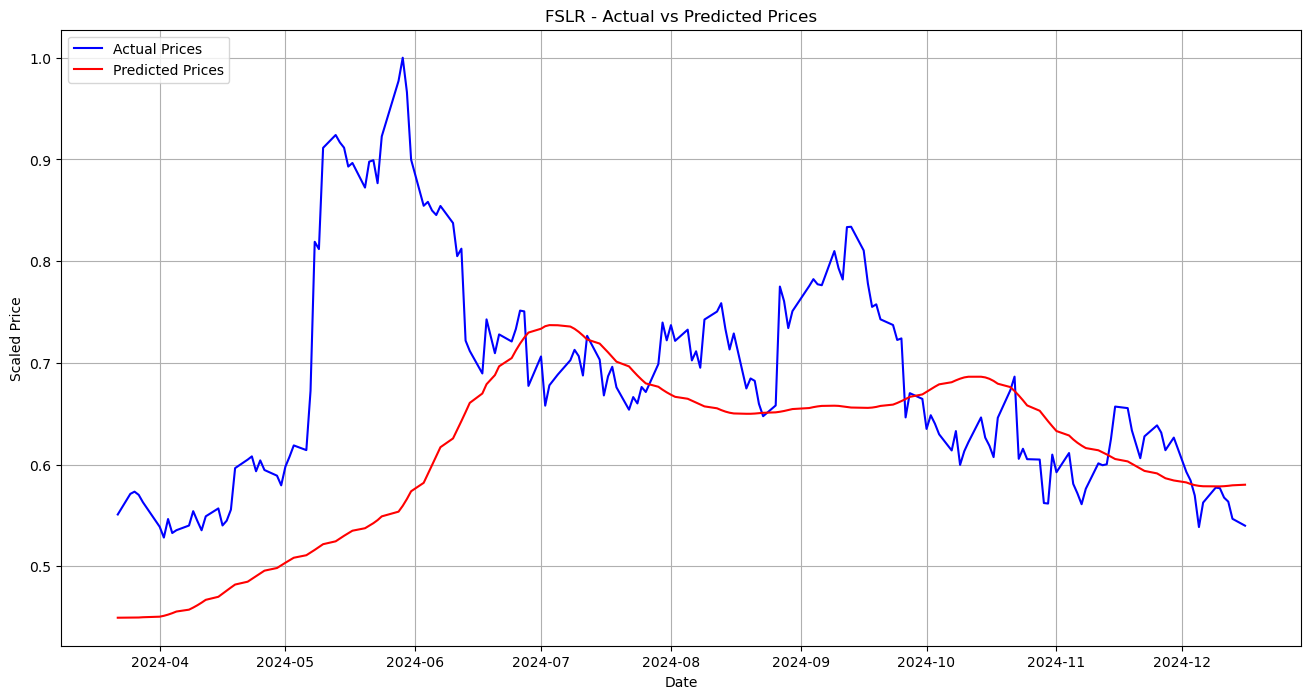

In [8]:
# --- Main Loop ---

results = []

for ticker in TICKERS:
    print(f"Processing: {ticker}")
    
    # Load and preprocess
    df, features = load_and_preprocess_data(ticker)
    
    # Calculate Volatility (30-day rolling std of daily returns)
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=30).std()
    
    df.dropna(inplace=True)

    # Split train/test
    split = int(len(df) * 0.8)
    train_df, test_df = df[:split], df[split:]

    # Sequence creation
    X_train, y_train = create_sequences(train_df, features, time_steps)
    X_test, y_test = create_sequences(test_df, features, time_steps)

    # Train model
    model = train_lstm_model(X_train, y_train, X_test, y_test)
    predictions = model.predict(X_test)

    # Expected return
    last_known_price = float(test_df.iloc[len(X_test) - 1]['Close'])
    predicted_price = float(predictions[-1][0])
    expected_return_pct = ((predicted_price - last_known_price) / last_known_price) * 100
    expected_return_daily = (predicted_price - last_known_price) / last_known_price  # decimal form

    # Volatility (%)
    latest_volatility = float(test_df['Volatility'].iloc[-1]) * 100
    volatility_value = float(test_df['Volatility'].iloc[-1]) + 1e-8  # avoid division by zero

    # Sharpe Ratio
    sharpe_ratio = (expected_return_daily - risk_free_rate_daily) / volatility_value

    # Sector lookup
    sector = SECTOR_MAP.get(ticker, "Unknown")

    # Save results
    results.append({
        'Ticker': ticker,
        'Expected Return (%)': expected_return_pct,
        'Volatility (%)': latest_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sector': sector
    })

    # Plotting
    start_index = time_steps
    end_index = time_steps + len(y_test)
    last_close_values_test = test_df.iloc[start_index:end_index].index

    plt.figure(figsize=(16, 8))
    plt.plot(last_close_values_test, y_test, label='Actual Prices', color='blue')
    plt.plot(last_close_values_test, predictions.flatten(), label='Predicted Prices', color='red')
    plt.xlabel('Date')
    plt.ylabel('Scaled Price')
    plt.title(f'{ticker} - Actual vs Predicted Prices')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


In [ ]:
from tabulate import tabulate

# --- Results Summary ---
ranked = sorted(results, key=lambda x: x['Sharpe Ratio'], reverse=True)

# Prepare the table headers and rows
table_headers = ["Ticker", "Sector", "Return (%)", "Volatility (%)", "Sharpe Ratio"]
table_rows = []

for r in ranked:
    table_rows.append([
        r['Ticker'],
        r['Sector'],
        f"{r['Expected Return (%)']:.2f}%", 
        f"{r['Volatility (%)']:.2f}%",      
        f"{r['Sharpe Ratio']:.2f}"           
    ])

# Print the results in a table format
print("\n📊 Stock Ranking Based on Sharpe Ratio:")
print(tabulate(table_rows, headers=table_headers, tablefmt="grid"))



📊 Stock Ranking Based on Sharpe Ratio:
+----------+----------+--------------+------------------+----------------+
| Ticker   | Sector   | Return (%)   | Volatility (%)   |   Sharpe Ratio |
+==========+==========+==============+==================+================+
| TSLA     | Tech     | 33.85%       | 4.78%            |           7.08 |
+----------+----------+--------------+------------------+----------------+
| ILMN     | Health   | 38.84%       | 6.61%            |           5.88 |
+----------+----------+--------------+------------------+----------------+
| NFLX     | Media    | 3.85%        | 1.81%            |           2.12 |
+----------+----------+--------------+------------------+----------------+
| AMZN     | Tech     | -5.43%       | 2.99%            |          -1.83 |
+----------+----------+--------------+------------------+----------------+
| MRNA     | Health   | -15.45%      | 7.22%            |          -2.14 |
+----------+----------+--------------+------------------+---